In [57]:
import numpy as np
import cv2
from PIL import Image
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import saved_model
import random, colorsys

from mss.linux import MSS as mss
# uncomment the following line if you are using windows
# from mss.windows import MSS as mss

In [58]:
import yolo_detector,util

In [61]:
def draw_bbox(image, bboxes, show_label=True):
    classes = util.read_class_names("./tensorflow-yolov4-tflite/data/classes/coco.names")
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    out_boxes, out_scores, out_classes, num_boxes = bboxes
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > num_classes: continue
        coor = out_boxes[0][i]
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)

        fontScale = 0.5
        score = out_scores[0][i]
        class_ind = int(out_classes[0][i])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[1], coor[0]), (coor[3], coor[2])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick // 2)[0]
            c3 = (c1[0] + t_size[0], c1[1] - t_size[1] - 3)
            cv2.rectangle(image, c1, (np.float32(c3[0]), np.float32(c3[1])), bbox_color, -1) #filled

            cv2.putText(image, bbox_mess, (c1[0], np.float32(c1[1] - 2)), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick // 2, lineType=cv2.LINE_AA)
    return image

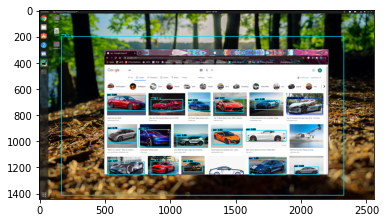

In [63]:
sct = mss()

while (True):
    with mss() as sct:
        sct_img = sct.grab(sct.monitors[1])

        # Create the Image
        img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")
        img = np.asarray(img)
        pred_bbox = yolo_detector(np.asarray(img))
        img = draw_bbox(img,pred_bbox)
        plt.imshow(img)
    break

In [ ]:
from PyQt5 import QtGui, QtCore
from PyQt5.QtWidgets import QMainWindow, QApplication
from PyQt5 import QtWidgets

In [ ]:
class MainWindow(QMainWindow):
    def __init__(self):
        QMainWindow.__init__(self)
        self.setWindowFlags(
            QtCore.Qt.WindowStaysOnTopHint |
            QtCore.Qt.FramelessWindowHint |
            QtCore.Qt.X11BypassWindowManagerHint
        )
        self.setGeometry(0,0)


if __name__ == '__main__':
    app = QApplication(sys.argv)
    mywindow = MainWindow()
    mywindow.show()
    app.exec_()